In [1]:
from active_learning import ActiveLearner

In [2]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
sns.set_theme(style='darkgrid')
warnings.filterwarnings("ignore")

In [4]:
X, y = make_classification(n_samples = 10000,
                           n_features = 10, n_informative = 7, n_redundant = 0,
                           flip_y = 0.025, n_clusters_per_class = 5, 
                           weights = np.array([0.9, 0.1]), class_sep = 3,
                           random_state = 30
                          )

In [5]:
print(f"Feature matrix dimensions: {X.shape} \nNumber of positive (friends in ReGroup paper) instances = {y.sum()} ({y.sum()*100 / len(y)}%) of out total {y.shape[0]}")

Feature matrix dimensions: (10000, 10) 
Number of positive (friends in ReGroup paper) instances = 1103 (11.03%) of out total 10000


<AxesSubplot:>

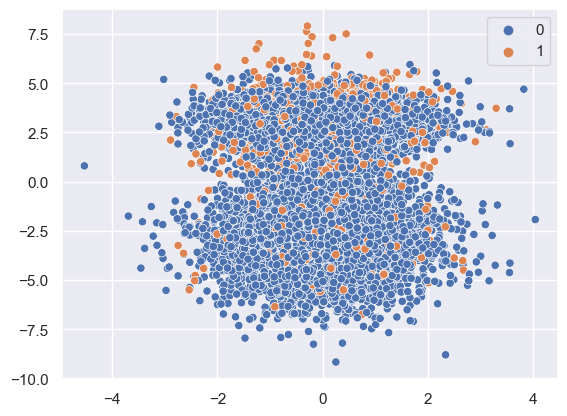

In [6]:
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y)

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate

In [8]:
clf = GaussianNB()
cv = StratifiedKFold(n_splits=10)
metrics = ['f1', 'accuracy']
scores = cross_validate(clf, X, y, scoring=metrics, cv = cv)

In [9]:
for metric in metrics:
    print(f"{metric}: {scores['test_' + metric].mean():.4f} \u00B1 {scores['test_' + metric].std():.4f}")

f1: 0.4957 ± 0.0361
accuracy: 0.9146 ± 0.0052


In [45]:
np.random.seed(19) #52
random_10_indices = np.random.choice(range(len(y)), 10)
X_initial_selection, y_initial_selection = X[random_10_indices, :], y[random_10_indices]

In [46]:
print(f"Number of positive cases in intial random 10 cases: {y_initial_selection.sum()}")

Number of positive cases in intial random 10 cases: 1


In [47]:
mask = np.ones(X.shape[0], dtype=bool)
mask[random_10_indices] = False
X_sample, y_sample = X[mask, :], y[mask]

In [48]:
X_sample.shape, y_sample.shape

((9990, 10), (9990,))

In [49]:
y_sample.sum()

1102

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, stratify=y_sample, test_size=0.20, random_state = 30)

print(f"Interactive Training Data Shape: {X_train.shape} , positive cases: {y_train.sum()}\nTest (Benchmark) Data Shape: {X_test.shape} , positive cases: {y_test.sum()}")

Interactive Training Data Shape: (7992, 10) , positive cases: 882
Test (Benchmark) Data Shape: (1998, 10) , positive cases: 220


In [51]:
regroup_perf = {}
regroup = ActiveLearner(X_initial_selection, y_initial_selection)
regroup_perf['f1'], regroup_perf['acc'] = regroup.initiate_interactive_training(X_train, y_train,
                                                                                strategy = 'regroup',
                                                                                unlearnable_group_discount_factor = 0.9, 
                                                                                X_benchmark=X_test, y_benchmark=y_test)

Using GaussianNB() by default


<AxesSubplot:>

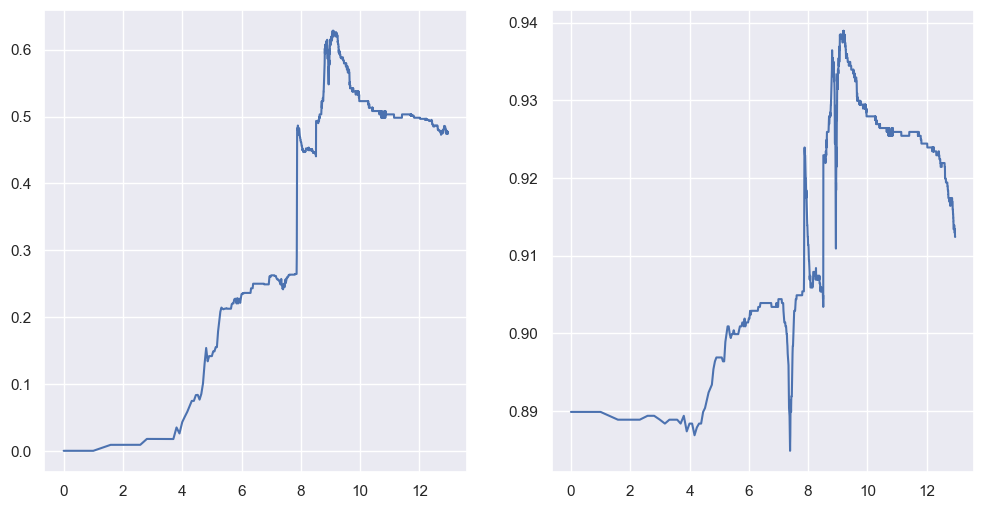

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12,6))
# sns.lineplot(y = acc_hist, x = list(range(0, len(acc_hist))), ax = ax1)
# sns.lineplot(y = f1_hist, x = list(range(0, len(f1_hist))), ax = ax2)

sns.lineplot(y = regroup_perf['f1'], x = np.log2(list(range(0, len(regroup_perf['f1'])))), ax = ax1)
sns.lineplot(y = regroup_perf['acc'], x = np.log2(list(range(0, len(regroup_perf['acc'])))), ax = ax2)

In [53]:
ubqs_perf = {}
ubqs = ActiveLearner(X_initial_selection, y_initial_selection)
ubqs_perf['f1'], ubqs_perf['acc'] = ubqs.initiate_interactive_training(X_train, y_train, strategy = 'UBQS',
                                                          relative_density_importance = 1, 
                                                          X_benchmark=X_test, y_benchmark=y_test)

Using GaussianNB() by default


<AxesSubplot:>

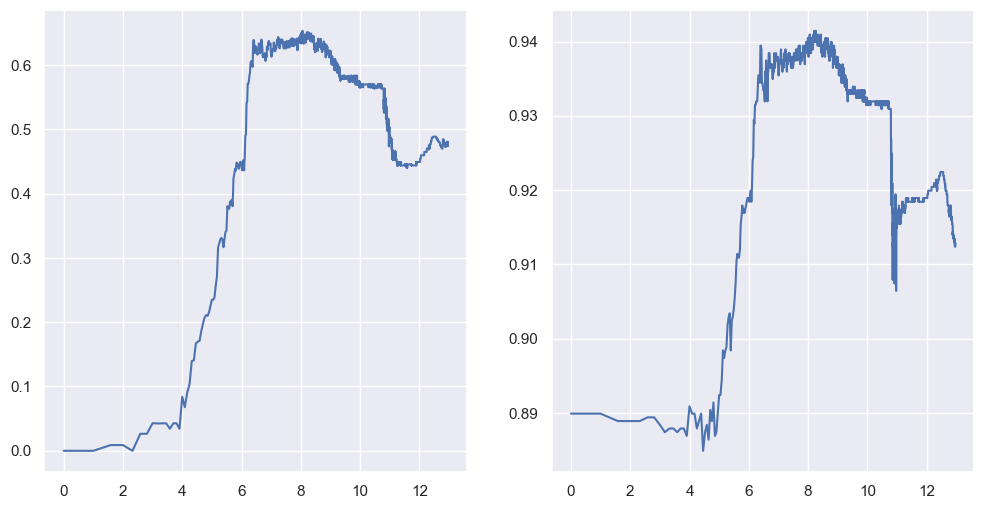

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12,6))
# sns.lineplot(y = acc_hist, x = list(range(0, len(acc_hist))), ax = ax1)
# sns.lineplot(y = f1_hist, x = list(range(0, len(f1_hist))), ax = ax2)

sns.lineplot(y = ubqs_perf['f1'], x = np.log2(list(range(0, len(ubqs_perf['f1'])))), ax = ax1)
sns.lineplot(y = ubqs_perf['acc'], x = np.log2(list(range(0, len(ubqs_perf['acc'])))), ax = ax2)

In [63]:
ubqs_id_perf = {}
ubqs_id = ActiveLearner(X_initial_selection, y_initial_selection)
ubqs_id_perf['f1'], ubqs_id_perf['acc'] = ubqs_id.initiate_interactive_training(X_train, y_train, strategy = 'information_density',
                                                                                X_benchmark=X_test, y_benchmark=y_test,
                                                                                relative_density_importance = 2)

Using GaussianNB() by default
{'relative_density_importance': 2}


In [64]:
ubqs_id.hyperparameters

{'beta': 2}

<AxesSubplot:>

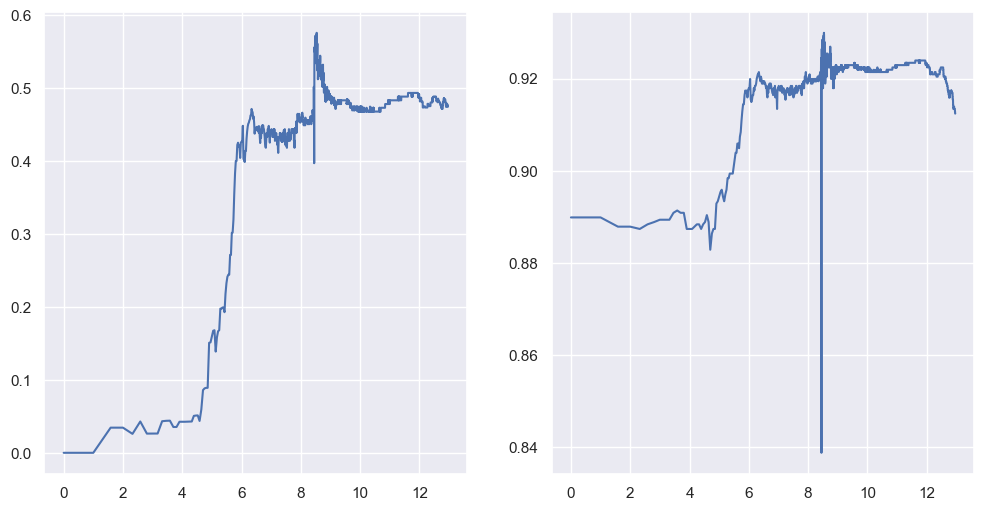

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12,6))
# sns.lineplot(y = ubqs_id_perf['acc'], x = list(range(0, len(ubqs_id_perf['acc']))), ax = ax1)
# sns.lineplot(y = ubqs_id_perf['f1'], x = list(range(0, len(ubqs_id_perf['f1']))), ax = ax2)

sns.lineplot(y = ubqs_id_perf['f1'], x = np.log2(list(range(0, len(ubqs_id_perf['f1'])))), ax = ax1)
sns.lineplot(y = ubqs_id_perf['acc'], x = np.log2(list(range(0, len(ubqs_id_perf['acc'])))), ax = ax2)

In [58]:
passive_perf = {}
passive_learner = ActiveLearner(X_initial_selection, y_initial_selection)
passive_perf['f1'], passive_perf['acc'] = passive_learner.initiate_interactive_training(X_train, y_train, strategy = 'passive_learning',
                                                                             X_benchmark=X_test, y_benchmark=y_test)

Using GaussianNB() by default
This strategy queries instaces at random and is used to benchmark other strategies


<AxesSubplot:>

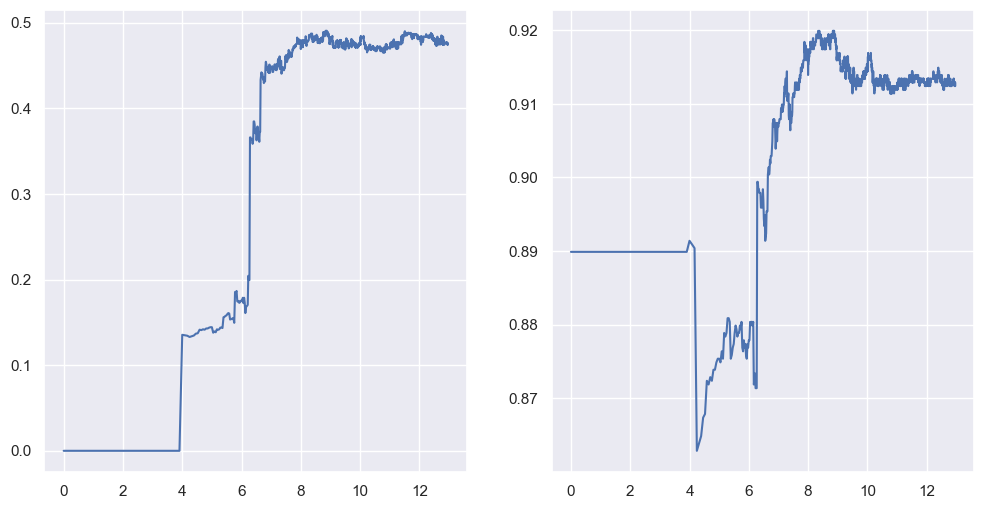

In [59]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12,6))
# sns.lineplot(y = passive_perf['acc'], x = list(range(0, len(passive_perf['acc']))), ax = ax1)
# sns.lineplot(y = passive_perf['f1'], x = list(range(0, len(passive_perf['f1']))), ax = ax2)

sns.lineplot(y = passive_perf['f1'], x = np.log2(list(range(0, len(passive_perf['f1'])))), ax = ax1)
sns.lineplot(y = passive_perf['acc'], x = np.log2(list(range(0, len(passive_perf['acc'])))), ax = ax2)